___________________________________________________________________________________
# Final Project: SMC Grade Distribution Analysis
- ## Dataset Creation
# Rachel Finley

    I decided that instead of using a Dataset from Kaggle, I'd finally do a project that I have been wanting to do for ages which is to scrape all of the grade distribution data from SMC's website which has Professor's grade distributions per class, per Semester and Year. I thought it would be a very hands-on and useful analysis project. The hope is that, after this week, I will continue to develop this into a web application which other students can use to probe the data, given the options of various statistical techniques. The grade distribution data itself, on the website, is disjointed and can be hard to navigate. So, consolidating and standardizing the whole dataset is the first step I've needed to take, albiet a daunting one. This code serves the purpose of building that dataset by:
    - Scraping the PDFs via HTML
    - Parsing those PDFs with a library into CSV's
        - Had to eventually use an online service due to non-homogeneity
    - Parsing those CSVs so they are in a legible format to be combined
    - Combine all Cleaned DFs into a CSV to perform analysis 
        - See how Average Grades and Withdraws Relate to eachother
        - Add functionality to graph grades by section
        - Add functionlity to graph teacher average grade per course for comparison
        
    I really wanted to try to push myself for this project, and apply everything that I have been learning!
_____________________________________________________________________________________________________

- ## Import Dependencies
_____________________________________________________________________________________________________

In [60]:
# !pip install pdfplubmber
# !pip install PyMuPDF
# !pip install tqdm
# !pip install statsmodels
# !pip install xgboost

In [99]:
# Web Scraping and File Manipulation
import os
import tempfile
import requests
from bs4 import BeautifulSoup

# PDF manipulation
import pdfplumber 
import fitz  # PyMuPDF
from IPython.display import display, Image

# Data Manipulation
import re
import pandas as pd
from tqdm import tqdm as tqdm

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

# ML Algorithms
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

_____________________________________________________________________________________________________
- ## Define a function to scrape the PDFs from the SMC website, luckily the HTML was pretty well organized and the PDFs are the only thing on the page with the class pdflink, making this process a whole lot easier
_____________________________________________________________________________________________________

In [3]:
def scrape_pdfs(url):
    # Grab the HTML from SMC's website
    response = requests.get(url)
    response.raise_for_status() # Request Error Handling
    html_content = response.text
    
    # Parse the scraped HTML
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Grade Distribution PDF's associated with the 'pdflink' class
    pdf_links = soup.find_all('a', class_='pdflink')
    
    # Save all of the path names to a list for later parsing
    paths_list = []
    
    for i, link in enumerate(pdf_links, 1):
        pdf_url = link['href']
        if not pdf_url.startswith('http'):
            pdf_url = f'https://www.smc.edu{pdf_url}' 
        
        # Get the PDF content
        response = requests.get(pdf_url)
        response.raise_for_status()  # Check for request errors
        
        # Get the PDF name from the URL
        pdf_name = os.path.basename(pdf_url)
        
        # Add name to names list
        paths_list.append(str(pdf_name))
        
        # Save the PDF to the current working directory
        with open(pdf_name, 'wb') as pdf_file:
            pdf_file.write(response.content)
            
    return paths_list

In [4]:
smc_grade_distro_url = 'https://www.smc.edu/administration/institutional-research/grade-distribution.php'
paths_list = scrape_pdfs(smc_grade_distro_url)
print(paths_list)

['Fall202GD2.pdf', 'spring-2022-grade-distribution.pdf', 'Grade-Distribution-Fall-2021.pdf', 'GradeDistribution_Spring2021.pdf', 'Fall_2020_Grade_Distribution.pdf', 'Spring_2020_Grade_Distribution.pdf', 'grade-distribution-fall-2019.pdf', 'grade-distribution-spring-2019.pdf', 'grade-distribution-fall-2018.pdf', 'grade-distribution-spring-2018.pdf', 'grade-distribution-fall-2017.pdf', 'grade-distribution-spring-2017.pdf', 'grade-distribution-fall-2016.pdf', 'grade-distribution-spring-2016.pdf']


_____________________________________________________________________________________________________
- ## It seems like there isn't really a standardization of the way that the data has been saved, so I am going to rename all of the files to something a little bit more structured
_____________________________________________________________________________________________________

In [5]:
def extract_season_year(filename):
    pattern = re.compile(r'(Fall|Spring)[-_]?(\d{4})', re.IGNORECASE)
    match = pattern.search(filename)
    if match:
        season, year = match.groups()
        return f'{season.capitalize()}_{year}.pdf'    

In [6]:
def rename_pdfs(file_list):
    new_paths_list = []
    for filename in file_list:
        new_name = extract_season_year(filename)
        new_paths_list.append(new_name)
        if new_name:
            os.rename(filename, new_name)
            
    return new_paths_list

In [7]:
new_paths_list = rename_pdfs(paths_list) 

# Edge Case
os.rename('Fall202GD2.pdf', 'Fall_2022.pdf')
new_paths_list[0] = 'Fall_2022.pdf'

print(" -PDFs have been renamed for convenience- ")
new_paths_list

 -PDFs have been renamed for convenience- 


['Fall_2022.pdf',
 'Spring_2022.pdf',
 'Fall_2021.pdf',
 'Spring_2021.pdf',
 'Fall_2020.pdf',
 'Spring_2020.pdf',
 'Fall_2019.pdf',
 'Spring_2019.pdf',
 'Fall_2018.pdf',
 'Spring_2018.pdf',
 'Fall_2017.pdf',
 'Spring_2017.pdf',
 'Fall_2016.pdf',
 'Spring_2016.pdf']

_____________________________________________________________________________________________________
- ## Now, lets visualize the output of the PDFs for some first impressions
_____________________________________________________________________________________________________

In [8]:
def display_first_page(pdf_list):
    for pdf_path in pdf_list:
        with fitz.open(pdf_path) as pdf_document:
            page = pdf_document.load_page(0)  # 0 is the page number
            image = page.get_pixmap()
            with tempfile.NamedTemporaryFile(delete=True, suffix=".png") as temp_file:
                image.save(temp_file.name)
                display(Image(filename=temp_file.name))

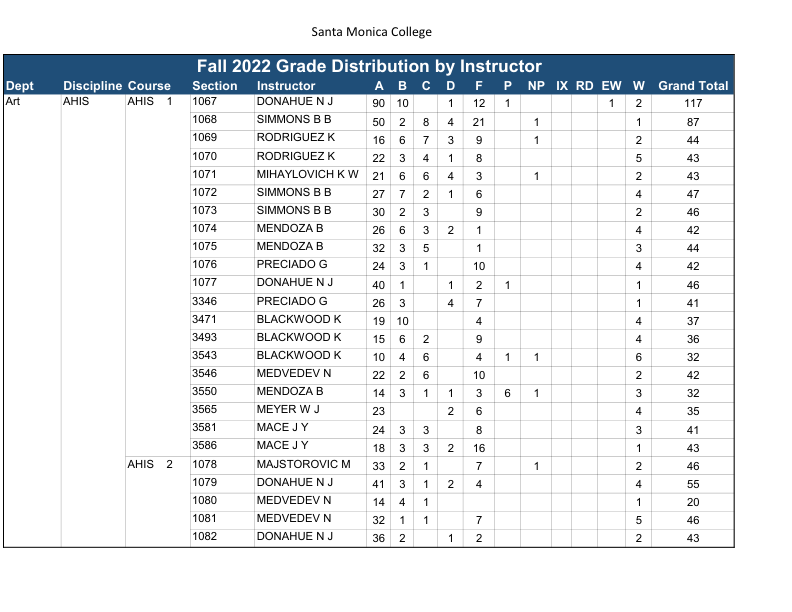

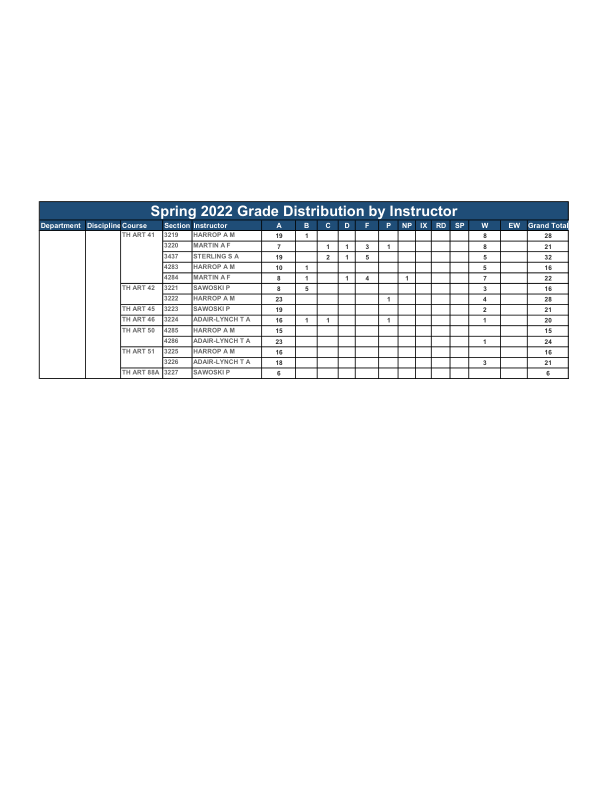

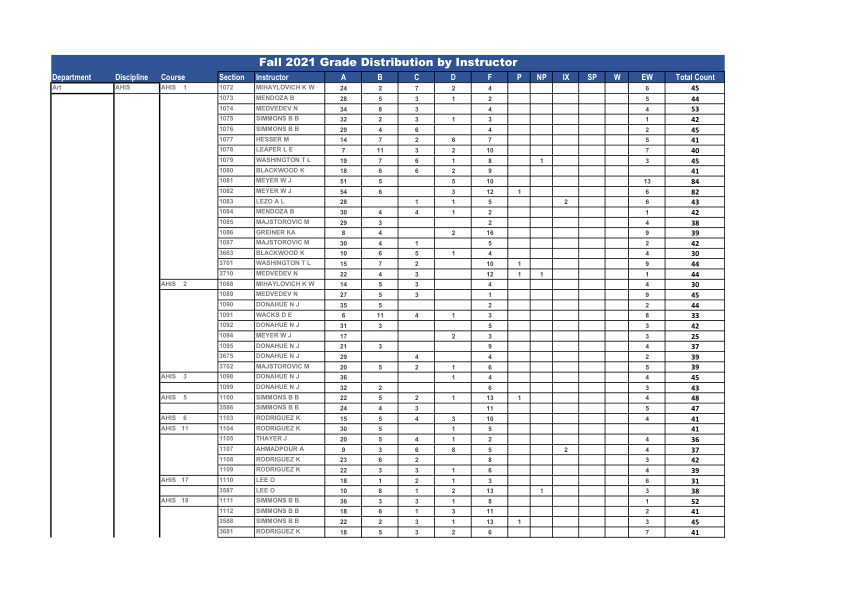

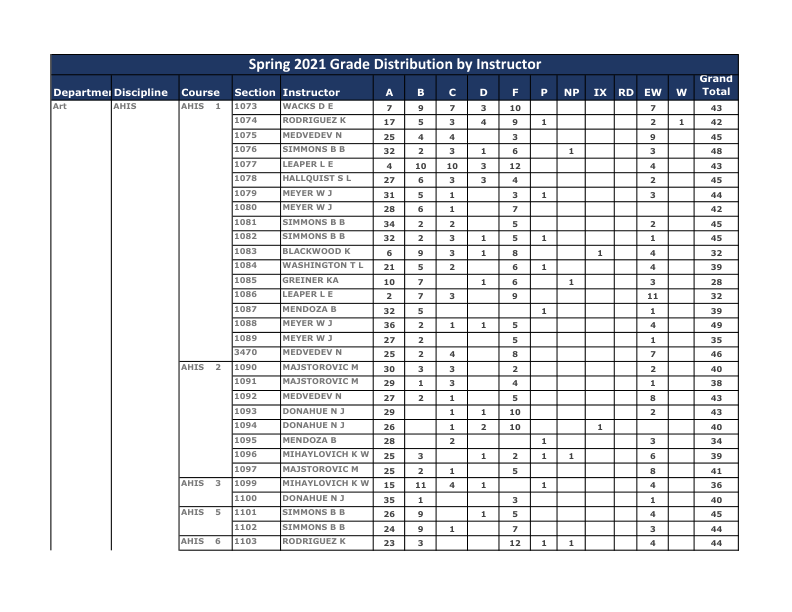

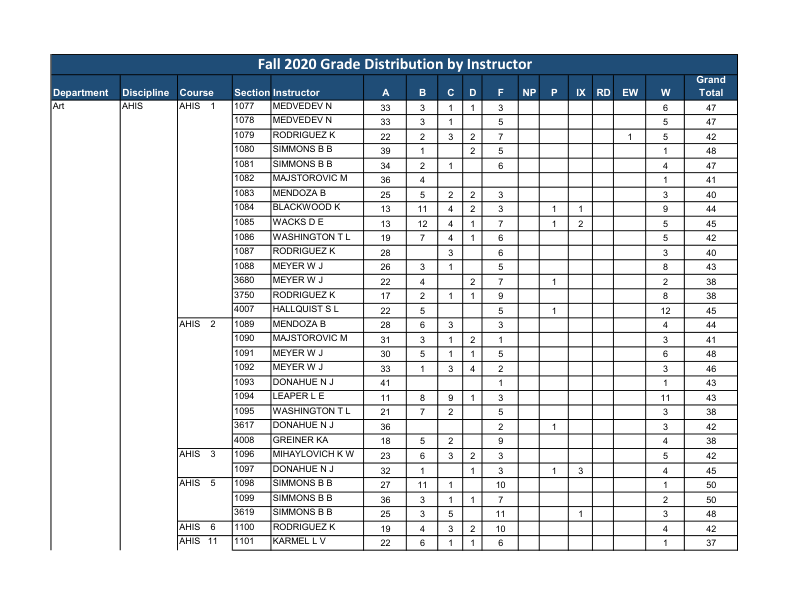

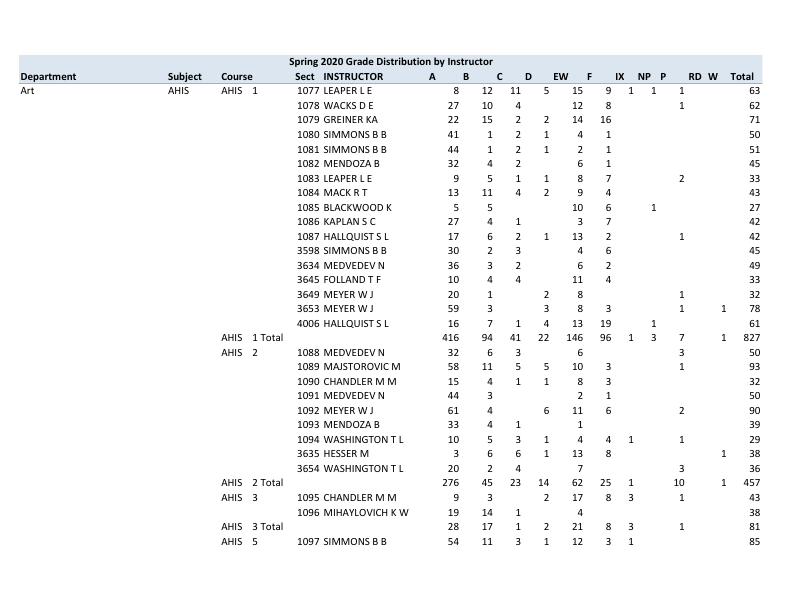

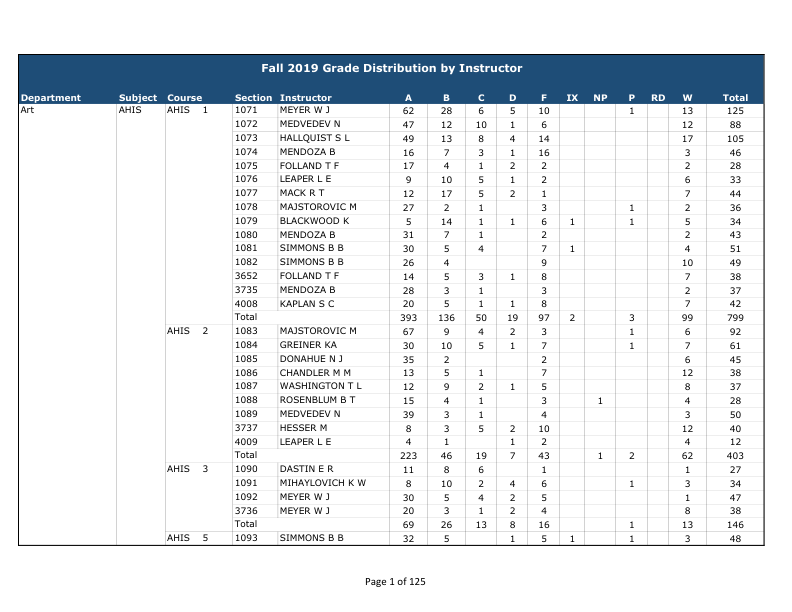

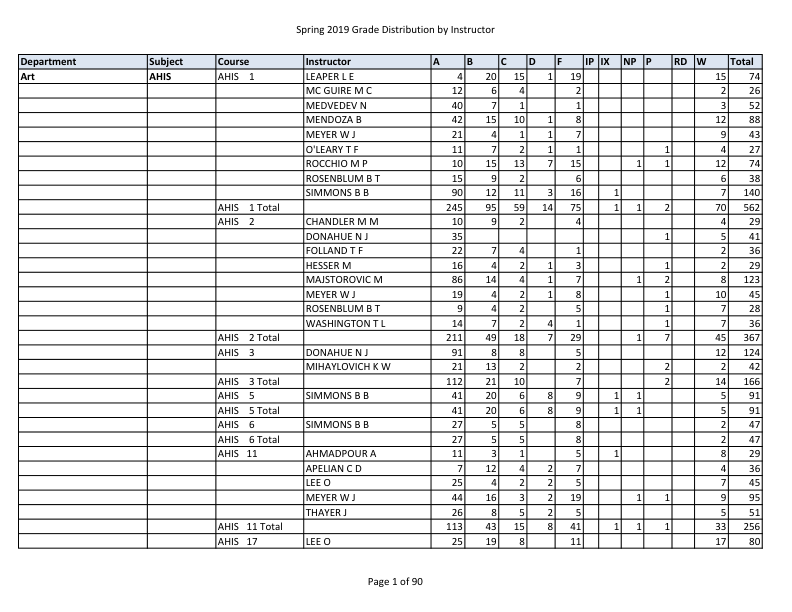

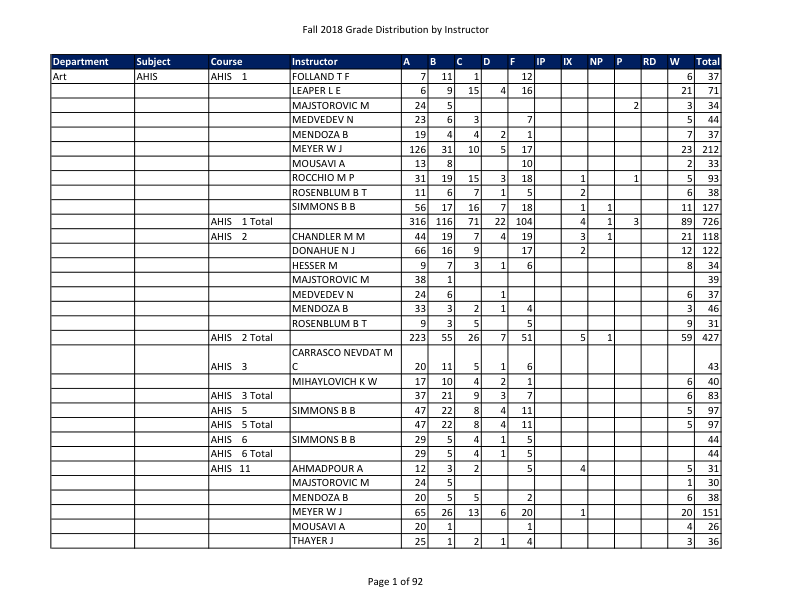

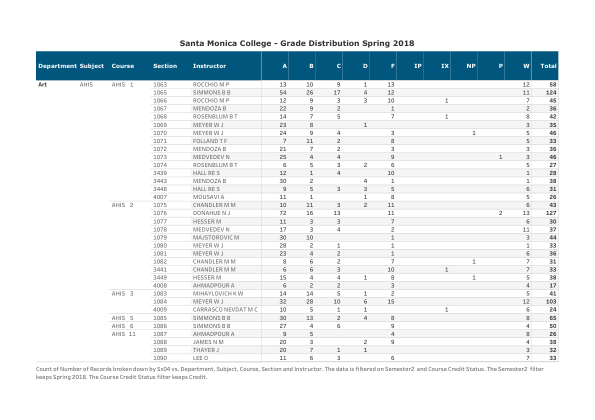

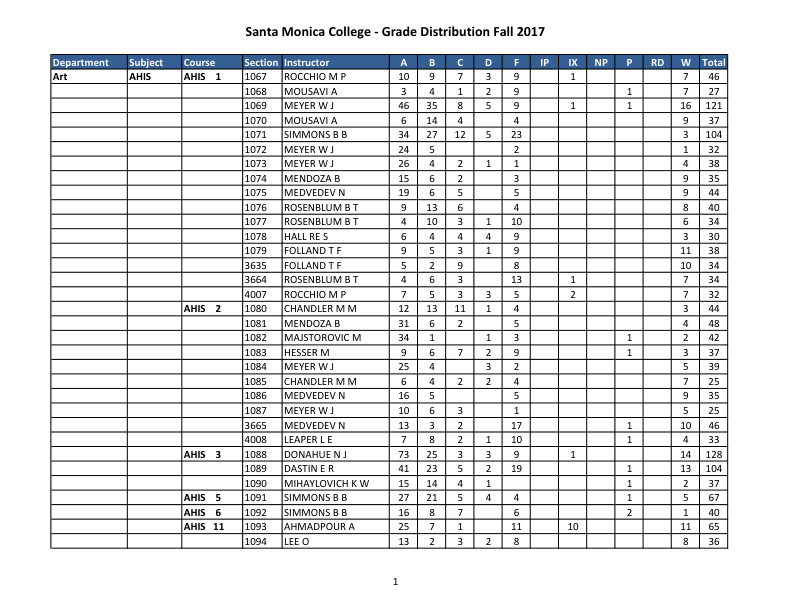

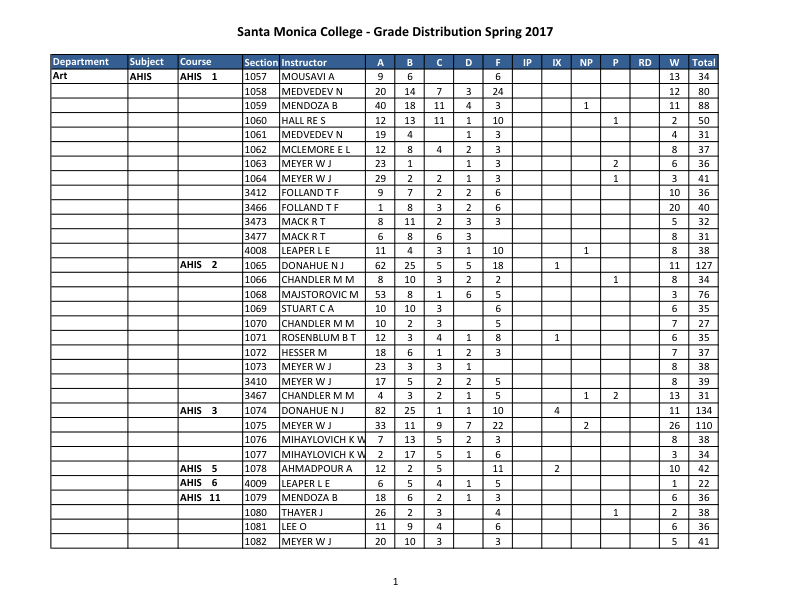

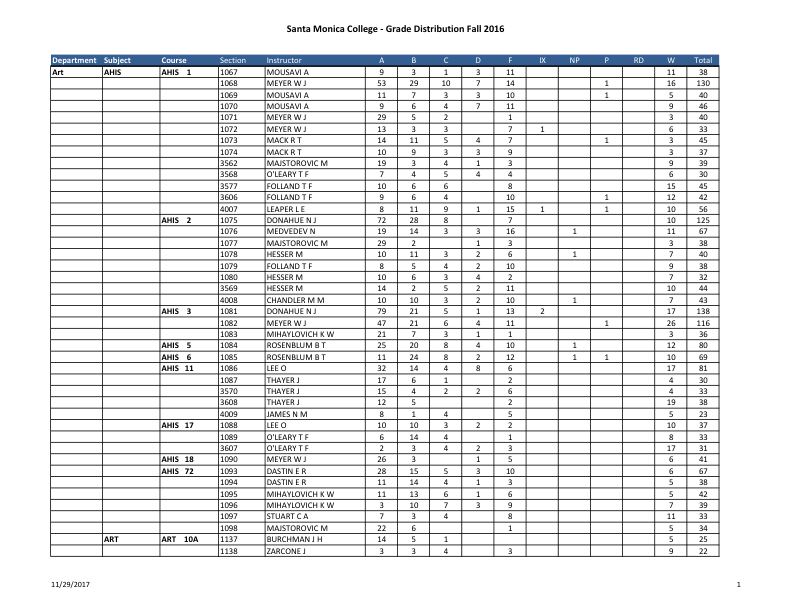

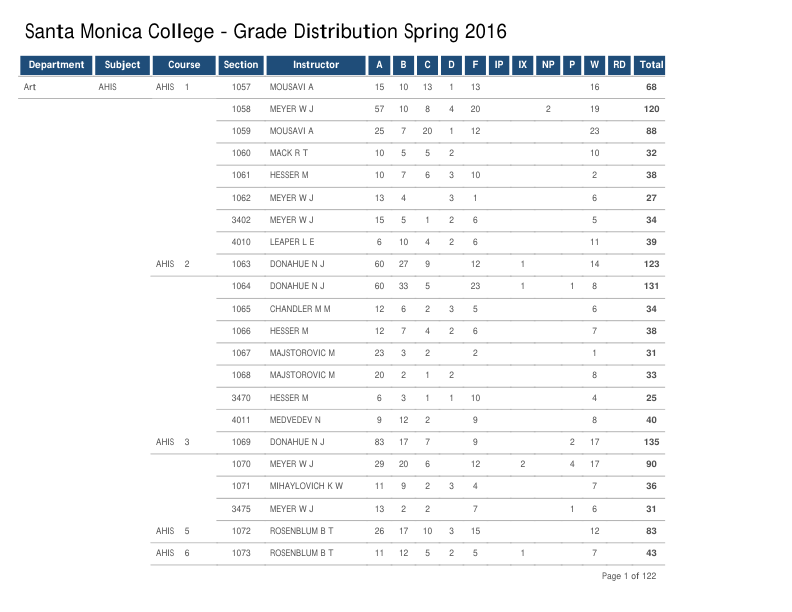

In [9]:
display_first_page(new_paths_list)

_____________________________________________________________________________________________________
- ## Something I am noticing right away is that a lot of the PDFs have slightly different styles, and it may be difficult to craft some kind of universally applicable cleaning function with these. The tool I am familiar with excels best when there is a grid separating table items. 
    - ## This furthers my previous suspicision that the way that data has been getting recorded at our campus has not been standardized over the years.
_____________________________________________________________________________________________________

In [10]:
def pdf_to_df(pdf_filename):
    with pdfplumber.open(pdf_filename) as pdf:
        # Initialize an empty list to store data frames
        dfs = []
        
        for page in pdf.pages:
            table = page.extract_table()
            if table is not None:
                # Define the header columns explicitly
                header = ['Dept', 'Discipline', 'Course', 'Section', 'Instructor', 'A', 'B', 'C', 'D', 'F', 'P', 'NP', 'IX', 'RD', 'EW', 'W', 'Grand Total']
                
                # Use the remaining rows as data, removing the None values
                data = [[cell for cell in row if cell is not None] for row in table]
                
                # Create a data frame
                df = pd.DataFrame(data, columns=header)
                dfs.append(df)

        return dfs

# Call the function with your PDF file
dfs = pdf_to_df('Fall_2020.pdf')


In [11]:
dfs[0].head()

,Dept,Discipline,Course,Section,Instructor,A,B,C,D,F,P,NP,IX,RD,EW,W,Grand Total
0,Fall 2020 Grade Distribution by Instructor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Department,Discipline,Course,Section,Instructor,A,B,C,D,F,NP,P,IX,RD,EW,W,Grand\nTotal
2,AHIS 1,1077,MEDVEDEV N,33,3,1,1,3,,,,,,6,47,None,None
3,1078,MEDVEDEV N,33,3,1,,5,,,,,,5,47,None,None,None
4,1079,RODRIGUEZ K,22,2,3,2,7,,,,,1,5,42,None,None,None


_____________________________________________________________________________________________________
# After a lot of trial and error, It is here that I sought a different solution than automating this process. All of the formats are slightly different, and I ended up spending too long on just this section. I found an adequate converter online and processed to .txt that way
- ### It ended up being that there were only 2 of the PDFs that produced parsable data in CSV form, so I am proceeding with the limited dataset due to the limited scope of the project, but will perform analysis on the data nonetheless.
    - ### Spring 2022 and Fall 2020 were the only ones salvagable in the timeframe
    - ### I saved the resultant CSVs to the same directory as this notebook
_____________________________________________________________________________________________________

In [12]:
parsable_csvs = ['Spring_2022.csv',
                 'Fall_2020.csv']

_____________________________________________________________________________________________________
- ## Parse and subsequently clean the data that has been extracted through the web service
    - ## Add year and semester columns
    - ## Comb through the dfs individually to homogenize the structure for easy concactenation
_____________________________________________________________________________________________________

In [13]:
def parse_csv(filename):
    # Extract the semester and year from the filename
    semester, year = filename.split('_')[0], filename.split('_')[1].split('.')[0]

    df = pd.read_csv(filename, skiprows=1, na_values=[''])
    # Add a column for year/semester
    df['Semester'] = semester
    df['Year'] = year
    
    # Drop the 'Department' and 'Discipline' columns due to a lack of data, which sucks since it would be interesting to explore relationships by department
    df.drop(columns=['Department', 'Discipline'], inplace=True)
    # Fill missing values in the 'Course' column
    df['Course'] = df['Course'].fillna(method='ffill')
    # Replace other missing values with 0s
    df.fillna(0, inplace=True)
    
    return df

In [14]:
df_list = []
for filename in parsable_csvs:
    df = parse_csv(filename)
    df_list.append(df)

In [15]:
df_list[0].head()

,Course,Section,Instructor,A,B,C,D,F,P,NP,IX,RD,SP,W,EW,Grand Total,Unnamed: 18,Semester,Year
0,TH ART 41,3219,HARROP A M,19,1,0,0,0,0,0,0,0,0,8,0,28,0.0,Spring,2022
1,TH ART 41,3220,MARTIN A F,7,0,1,1,3,1,0,0,0,0,8,0,21,0.0,Spring,2022
2,TH ART 41,3437,STERLING S A,19,0,2,1,5,0,0,0,0,0,5,0,32,0.0,Spring,2022
3,TH ART 41,4283,HARROP A M,10,1,0,0,0,0,0,0,0,0,5,0,16,0.0,Spring,2022
4,TH ART 41,4284,MARTIN A F,8,1,0,1,4,0,1,0,0,0,7,0,22,0.0,Spring,2022


In [16]:
df_list[0].drop(columns = ['SP', 'Unnamed: 18'], inplace = True)
df_list[0].head()

,Course,Section,Instructor,A,B,C,D,F,P,NP,IX,RD,W,EW,Grand Total,Semester,Year
0,TH ART 41,3219,HARROP A M,19,1,0,0,0,0,0,0,0,8,0,28,Spring,2022
1,TH ART 41,3220,MARTIN A F,7,0,1,1,3,1,0,0,0,8,0,21,Spring,2022
2,TH ART 41,3437,STERLING S A,19,0,2,1,5,0,0,0,0,5,0,32,Spring,2022
3,TH ART 41,4283,HARROP A M,10,1,0,0,0,0,0,0,0,5,0,16,Spring,2022
4,TH ART 41,4284,MARTIN A F,8,1,0,1,4,0,1,0,0,7,0,22,Spring,2022


In [17]:

df_list[1].head()

,Course,Section,Instructor,A,B,C,D,F,NP,P,IX,RD,EW,W,Grand\nTotal,Unnamed: 17,Semester,Year
0,AHIS 1,1077,MEDVEDEV N,33,3,1,1,3,0,0,0,0,0,6,47,0.0,Fall,2020
1,AHIS 1,1078,MEDVEDEV N,33,3,1,0,5,0,0,0,0,0,5,47,0.0,Fall,2020
2,AHIS 1,1079,RODRIGUEZ K,22,2,3,2,7,0,0,0,0,1,5,42,0.0,Fall,2020
3,AHIS 1,1080,SIMMONS B B,39,1,0,2,5,0,0,0,0,0,1,48,0.0,Fall,2020
4,AHIS 1,1081,SIMMONS B B,34,2,1,0,6,0,0,0,0,0,4,47,0.0,Fall,2020


In [18]:
df_list[1].drop(columns=['Unnamed: 17'], inplace = True)
df_list[1].rename(columns={'Grand\nTotal': 'Grand Total'}, inplace=True)
df_list[1].head()

,Course,Section,Instructor,A,B,C,D,F,NP,P,IX,RD,EW,W,Grand Total,Semester,Year
0,AHIS 1,1077,MEDVEDEV N,33,3,1,1,3,0,0,0,0,0,6,47,Fall,2020
1,AHIS 1,1078,MEDVEDEV N,33,3,1,0,5,0,0,0,0,0,5,47,Fall,2020
2,AHIS 1,1079,RODRIGUEZ K,22,2,3,2,7,0,0,0,0,1,5,42,Fall,2020
3,AHIS 1,1080,SIMMONS B B,39,1,0,2,5,0,0,0,0,0,1,48,Fall,2020
4,AHIS 1,1081,SIMMONS B B,34,2,1,0,6,0,0,0,0,0,4,47,Fall,2020


In [19]:
# Concatenate the DataFrames
combined_df = pd.concat(df_list, ignore_index=True, axis=0, sort=True)
combined_df.head()

,A,B,C,Course,D,EW,F,Grand Total,IX,Instructor,NP,P,RD,Section,Semester,W,Year
0,19,1,0,TH ART 41,0,0,0,28,0,HARROP A M,0,0,0,3219,Spring,8,2022
1,7,0,1,TH ART 41,1,0,3,21,0,MARTIN A F,0,1,0,3220,Spring,8,2022
2,19,0,2,TH ART 41,1,0,5,32,0,STERLING S A,0,0,0,3437,Spring,5,2022
3,10,1,0,TH ART 41,0,0,0,16,0,HARROP A M,0,0,0,4283,Spring,5,2022
4,8,1,0,TH ART 41,1,0,4,22,0,MARTIN A F,1,0,0,4284,Spring,7,2022


_____________________________________________________________________________________________________
- ## Make a checkpoint by saving the data in the form of the combined dataframe, and moving to basic preprocessing
    - ## Look for NA values, and possible leftover columns with bad data
_____________________________________________________________________________________________________


In [20]:
combined_df.to_csv("Spring_2022_Fall_2020_Combined_Grade_Distro_Data.csv", index=False)

In [21]:
df = pd.read_csv("Spring_2022_Fall_2020_Combined_Grade_Distro_Data.csv")

In [22]:
df

,A,B,C,Course,D,EW,F,Grand Total,IX,Instructor,NP,P,RD,Section,Semester,W,Year
0,19,1,0,TH ART 41,0,0,0,28,0,HARROP A M,0,0,0,3219,Spring,8,2022
1,7,0,1,TH ART 41,1,0,3,21,0,MARTIN A F,0,1,0,3220,Spring,8,2022
2,19,0,2,TH ART 41,1,0,5,32,0,STERLING S A,0,0,0,3437,Spring,5,2022
3,10,1,0,TH ART 41,0,0,0,16,0,HARROP A M,0,0,0,4283,Spring,5,2022
4,8,1,0,TH ART 41,1,0,4,22,0,MARTIN A F,1,0,0,4284,Spring,7,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,A,B,C,Course,D,EW,F,Grand\nTotal,IX,Instructor,NP,P,RD,Section,Fall,W,2020
5516,14,0,0,TH ART 51,0,0,0,15,0,SAWOSKI P,0,1,0,3521,Fall,0,2020
5517,7,0,0,TH ART 55,0,0,0,7,0,HARROP A M,0,0,0,3523,Fall,0,2020
5518,2,0,0,TH ART 88A,0,0,0,3,0,SAWOSKI P,0,1,0,3524,Fall,0,2020


In [23]:
df.isnull().sum()

A              0
B              0
C              0
Course         0
D              0
EW             0
F              0
Grand Total    0
IX             0
Instructor     0
NP             0
P              0
RD             0
Section        0
Semester       0
W              0
Year           0
dtype: int64

In [24]:
df.dtypes

A              object
B              object
C              object
Course         object
D              object
EW             object
F              object
Grand Total    object
IX             object
Instructor     object
NP             object
P              object
RD             object
Section        object
Semester       object
W              object
Year            int64
dtype: object

In [25]:
df

,A,B,C,Course,D,EW,F,Grand Total,IX,Instructor,NP,P,RD,Section,Semester,W,Year
0,19,1,0,TH ART 41,0,0,0,28,0,HARROP A M,0,0,0,3219,Spring,8,2022
1,7,0,1,TH ART 41,1,0,3,21,0,MARTIN A F,0,1,0,3220,Spring,8,2022
2,19,0,2,TH ART 41,1,0,5,32,0,STERLING S A,0,0,0,3437,Spring,5,2022
3,10,1,0,TH ART 41,0,0,0,16,0,HARROP A M,0,0,0,4283,Spring,5,2022
4,8,1,0,TH ART 41,1,0,4,22,0,MARTIN A F,1,0,0,4284,Spring,7,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,A,B,C,Course,D,EW,F,Grand\nTotal,IX,Instructor,NP,P,RD,Section,Fall,W,2020
5516,14,0,0,TH ART 51,0,0,0,15,0,SAWOSKI P,0,1,0,3521,Fall,0,2020
5517,7,0,0,TH ART 55,0,0,0,7,0,HARROP A M,0,0,0,3523,Fall,0,2020
5518,2,0,0,TH ART 88A,0,0,0,3,0,SAWOSKI P,0,1,0,3524,Fall,0,2020


In [26]:
# columns_to_convert = ['A', 'B', 'C', 'D', 'F', 'EW', 'W', 'P', 'NP', 'RD', 'Section', 'Grand Total']
# df[columns_to_convert] = df[columns_to_convert].astype(int)
# This code ended up throwing a value error

_____________________________________________________________________________________________________
- ## Well, its looking like the PDF scanner didn't work as well as I'd hoped but there is stil lots of salvagable data. I am going to go through and delete columns that throw an error when I try to convert them
_____________________________________________________________________________________________________


In [27]:
index_to_drop = []

for index, value in df['A'].items():
    try:
        int(value)
    except ValueError:
        index_to_drop.append(index)
        
df.drop(index_to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,A,B,C,Course,D,EW,F,Grand Total,IX,Instructor,NP,P,RD,Section,Semester,W,Year
0,19,1,0,TH ART 41,0,0,0,28,0,HARROP A M,0,0,0,3219,Spring,8,2022
1,7,0,1,TH ART 41,1,0,3,21,0,MARTIN A F,0,1,0,3220,Spring,8,2022
2,19,0,2,TH ART 41,1,0,5,32,0,STERLING S A,0,0,0,3437,Spring,5,2022
3,10,1,0,TH ART 41,0,0,0,16,0,HARROP A M,0,0,0,4283,Spring,5,2022
4,8,1,0,TH ART 41,1,0,4,22,0,MARTIN A F,1,0,0,4284,Spring,7,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,0,0,0,TH ART 50,0,0,0,0,0,0,0,0,0,0,Fall,0,2020
5333,14,0,0,TH ART 51,0,0,0,15,0,SAWOSKI P,0,1,0,3521,Fall,0,2020
5334,7,0,0,TH ART 55,0,0,0,7,0,HARROP A M,0,0,0,3523,Fall,0,2020
5335,2,0,0,TH ART 88A,0,0,0,3,0,SAWOSKI P,0,1,0,3524,Fall,0,2020


_____________________________________________________________________________________________________
- ## We didn't get rid of too much data, although there is still the problem of nearly half of the grand total column being NaN values. So, I'm just going to replace the values with aggregate of all of the count values, as Grand Total is just a calculated field in the first place
_____________________________________________________________________________________________________


In [28]:
columns_to_convert = ['A', 'B', 'C', 'D', 'F', 'EW', 'W', 'P', 'NP']
df[columns_to_convert] = df[columns_to_convert].astype(int)

student_count_cols = ['A', 'B', 'C', 'D', 'F', 'EW', 'W']
df['Grand Total'] = (df['A'] + df['B'] + df['C'] + df['D'] + df['F'] + df['EW'] + df['W'] + df['P'] + df['NP'])

In [29]:
df.dtypes

A               int32
B               int32
C               int32
Course         object
D               int32
EW              int32
F               int32
Grand Total     int32
IX             object
Instructor     object
NP              int32
P               int32
RD             object
Section        object
Semester       object
W               int32
Year            int64
dtype: object

In [30]:
df

,A,B,C,Course,D,EW,F,Grand Total,IX,Instructor,NP,P,RD,Section,Semester,W,Year
0,19,1,0,TH ART 41,0,0,0,28,0,HARROP A M,0,0,0,3219,Spring,8,2022
1,7,0,1,TH ART 41,1,0,3,21,0,MARTIN A F,0,1,0,3220,Spring,8,2022
2,19,0,2,TH ART 41,1,0,5,32,0,STERLING S A,0,0,0,3437,Spring,5,2022
3,10,1,0,TH ART 41,0,0,0,16,0,HARROP A M,0,0,0,4283,Spring,5,2022
4,8,1,0,TH ART 41,1,0,4,22,0,MARTIN A F,1,0,0,4284,Spring,7,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,0,0,0,TH ART 50,0,0,0,0,0,0,0,0,0,0,Fall,0,2020
5333,14,0,0,TH ART 51,0,0,0,15,0,SAWOSKI P,0,1,0,3521,Fall,0,2020
5334,7,0,0,TH ART 55,0,0,0,7,0,HARROP A M,0,0,0,3523,Fall,0,2020
5335,2,0,0,TH ART 88A,0,0,0,3,0,SAWOSKI P,0,1,0,3524,Fall,0,2020


_____________________________________________________________________________________________________
- ## Sweet, that mostly takes care of it. From here we can probably just drop any rows that have 0 in the grand total column.
_____________________________________________________________________________________________________


In [31]:
df = df[df['Grand Total'] != 0]
df

,A,B,C,Course,D,EW,F,Grand Total,IX,Instructor,NP,P,RD,Section,Semester,W,Year
0,19,1,0,TH ART 41,0,0,0,28,0,HARROP A M,0,0,0,3219,Spring,8,2022
1,7,0,1,TH ART 41,1,0,3,21,0,MARTIN A F,0,1,0,3220,Spring,8,2022
2,19,0,2,TH ART 41,1,0,5,32,0,STERLING S A,0,0,0,3437,Spring,5,2022
3,10,1,0,TH ART 41,0,0,0,16,0,HARROP A M,0,0,0,4283,Spring,5,2022
4,8,1,0,TH ART 41,1,0,4,22,0,MARTIN A F,1,0,0,4284,Spring,7,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,14,0,0,TH ART 50,0,0,0,15,0,OCAMPO C,0,1,0,4390,Fall,0,2020
5333,14,0,0,TH ART 51,0,0,0,15,0,SAWOSKI P,0,1,0,3521,Fall,0,2020
5334,7,0,0,TH ART 55,0,0,0,7,0,HARROP A M,0,0,0,3523,Fall,0,2020
5335,2,0,0,TH ART 88A,0,0,0,3,0,SAWOSKI P,0,1,0,3524,Fall,0,2020


_____________________________________________________________________________________________________
- ### Now I want to add some new columns for intentful analysis
    - ### Passing Grade Percentage
        - ### I want to see if there is a relationship between class size and passing rate
        - ### I want to compare pandemic vs post pandemic passing rates

    - ### Withdraw Rate
        - ### I want to see if there is a relationship between class size and withdraw rate
        - ### I want to compare pandemic vs post pandemic withraw rates
_____________________________________________________________________________________________________

In [32]:
df = df.copy()
df.loc[:,'Passing_Grade_Percentage'] = round((((df['A'] + df['B'] + df['C'] + df['P']) / df['Grand Total']) * 100))
df.loc[:,'Withdrawal_Rate'] = round(((df['EW'] + df['W']) / df['Grand Total']) * 100)

df

,A,B,C,Course,D,EW,F,Grand Total,IX,Instructor,NP,P,RD,Section,Semester,W,Year,Passing_Grade_Percentage,Withdrawal_Rate
0,19,1,0,TH ART 41,0,0,0,28,0,HARROP A M,0,0,0,3219,Spring,8,2022,71.0,29.0
1,7,0,1,TH ART 41,1,0,3,21,0,MARTIN A F,0,1,0,3220,Spring,8,2022,43.0,38.0
2,19,0,2,TH ART 41,1,0,5,32,0,STERLING S A,0,0,0,3437,Spring,5,2022,66.0,16.0
3,10,1,0,TH ART 41,0,0,0,16,0,HARROP A M,0,0,0,4283,Spring,5,2022,69.0,31.0
4,8,1,0,TH ART 41,1,0,4,22,0,MARTIN A F,1,0,0,4284,Spring,7,2022,41.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,14,0,0,TH ART 50,0,0,0,15,0,OCAMPO C,0,1,0,4390,Fall,0,2020,100.0,0.0
5333,14,0,0,TH ART 51,0,0,0,15,0,SAWOSKI P,0,1,0,3521,Fall,0,2020,100.0,0.0
5334,7,0,0,TH ART 55,0,0,0,7,0,HARROP A M,0,0,0,3523,Fall,0,2020,100.0,0.0
5335,2,0,0,TH ART 88A,0,0,0,3,0,SAWOSKI P,0,1,0,3524,Fall,0,2020,100.0,0.0


_____________________________________________________________________________________________________
- ## I am going to go ahead and drop columns that I will not use in my analysis
_____________________________________________________________________________________________________

In [33]:
to_drop = ['IX', 'RD']
df.drop(columns=to_drop, inplace=True)

_______________________________________________________________________________________________________________
- ## There does look to be some amount of linear relationship here, although there are a lot of outliers in both columns that lie outside of the standard deviation by a fair bit
    - ## Lets use the IQR method to process the data further
_______________________________________________________________________________________________________________

In [46]:
def remove_outliers(df, columns):
    clean_df = df.copy()
    for col in columns:
        Q1 = clean_df[col].quantile(0.25)  # First quartile (Q1)
        Q3 = clean_df[col].quantile(0.75)  # Third quartile (Q3)
        IQR = Q3 - Q1  # Interquartile range (IQR)
        
        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        clean_df = clean_df[(clean_df[col] >= lower_bound) & (clean_df[col] <= upper_bound)]
        
    return clean_df

In [51]:
cleaned_df = remove_outliers(df, ['Grand Total', 'Withdrawal_Rate', 'Passing_Grade_Percentage'])
cleaned_df

,A,B,C,Course,D,EW,F,Grand Total,Instructor,NP,P,Section,Semester,W,Year,Passing_Grade_Percentage,Withdrawal_Rate
0,19,1,0,TH ART 41,0,0,0,28,HARROP A M,0,0,3219,Spring,8,2022,71.0,29.0
1,7,0,1,TH ART 41,1,0,3,21,MARTIN A F,0,1,3220,Spring,8,2022,43.0,38.0
2,19,0,2,TH ART 41,1,0,5,32,STERLING S A,0,0,3437,Spring,5,2022,66.0,16.0
3,10,1,0,TH ART 41,0,0,0,16,HARROP A M,0,0,4283,Spring,5,2022,69.0,31.0
4,8,1,0,TH ART 41,1,0,4,22,MARTIN A F,1,0,4284,Spring,7,2022,41.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,14,0,0,TH ART 50,0,0,0,15,OCAMPO C,0,1,4390,Fall,0,2020,100.0,0.0
5333,14,0,0,TH ART 51,0,0,0,15,SAWOSKI P,0,1,3521,Fall,0,2020,100.0,0.0
5334,7,0,0,TH ART 55,0,0,0,7,HARROP A M,0,0,3523,Fall,0,2020,100.0,0.0
5335,2,0,0,TH ART 88A,0,0,0,3,SAWOSKI P,0,1,3524,Fall,0,2020,100.0,0.0


_______________________________________________________________________________________________________________
- ## Is there a relationship between class size and percent of passing grades?
_______________________________________________________________________________________________________________

Correlation coefficient: 0.07145481479894727


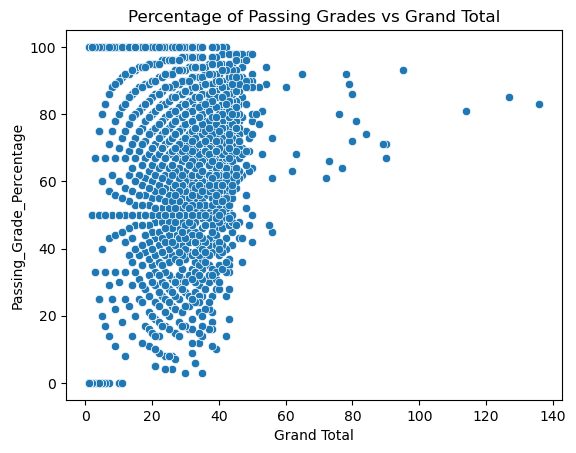

In [57]:
correlation = df['Grand Total'].corr(df['Passing_Grade_Percentage'])
plt.title("Percentage of Passing Grades vs Grand Total")
sns.scatterplot(x=df['Grand Total'], y = df['Passing_Grade_Percentage'])
print(f'Correlation coefficient: {correlation}')

In [68]:
X = df[['Grand Total']]  # predictor
y = df['Passing_Grade_Percentage'] # outcome
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit()
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     Passing_Grade_Percentage   R-squared:                       0.005
Model:                                  OLS   Adj. R-squared:                  0.005
Method:                       Least Squares   F-statistic:                     26.55
Date:                      Thu, 26 Oct 2023   Prob (F-statistic):           2.67e-07
Time:                              01:49:09   Log-Likelihood:                -23385.
No. Observations:                      5175   AIC:                         4.677e+04
Df Residuals:                          5173   BIC:                         4.679e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

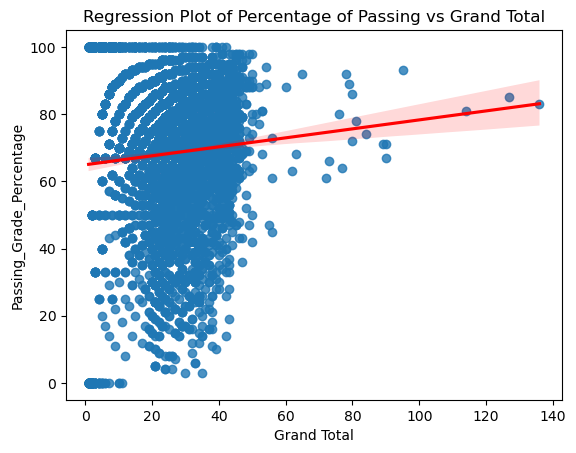

R-squared value: 0.005105790557951795


In [70]:
sns.regplot(x='Grand Total', y='Passing_Grade_Percentage', data=df, line_kws={'color':'red'})
plt.title("Regression Plot of Percentage of Passing vs Grand Total")
plt.show()
r_squared = model.rsquared
print(f'R-squared value: {r_squared}')

_______________________________________________________________________________________________________________
- ## This R squared value is telling us that a regression model in this case is quite litterally the same as using the mean to predict the values. As a heuristic, from previous studies done, I had assumed that there would be a stronger relationship between class size and performance. Maybe if I was able to sort by department, there could be some more interesting relationships to explore. Also, some of the more extreme values that remained even after IQR proccessing are throwing of the predictability of the regression model.
_______________________________________________________________________________________________________________

_______________________________________________________________________________________________________________
- ## Is there a relationship between class size and percent of withdraws?
_______________________________________________________________________________________________________________

Correlation coefficient: -0.1802415711220269


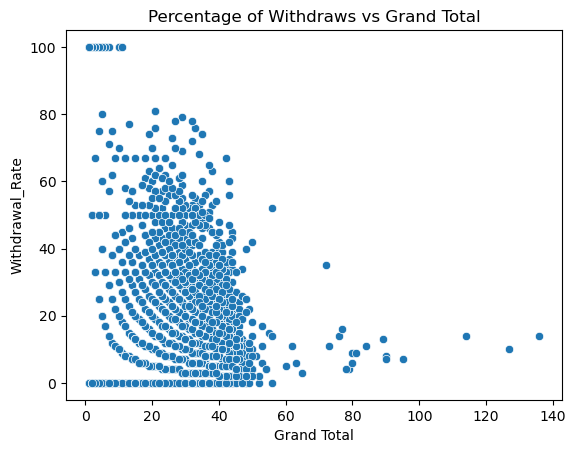

In [65]:
correlation = df['Grand Total'].corr(df['Withdrawal_Rate'])
plt.title("Percentage of Withdraws vs Grand Total")
sns.scatterplot(x=df['Grand Total'], y = df['Withdrawal_Rate'])
print(f'Correlation coefficient: {correlation}')

In [67]:
X = df[['Grand Total']]  # predictor
y = df['Withdrawal_Rate']  # outcome
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Withdrawal_Rate   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     173.7
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           4.88e-39
Time:                        01:48:37   Log-Likelihood:                -22239.
No. Observations:                5175   AIC:                         4.448e+04
Df Residuals:                    5173   BIC:                         4.450e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          25.4544      0.599     42.524      

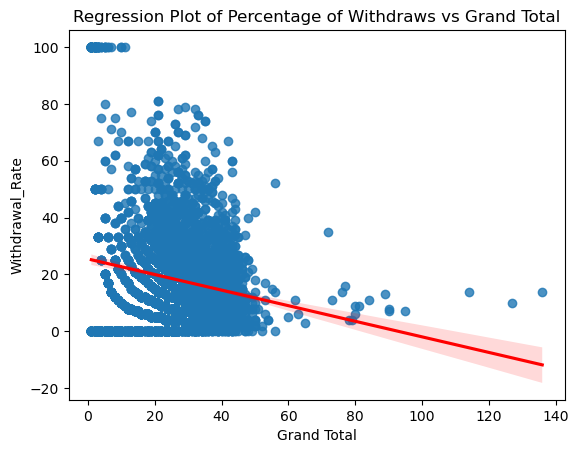

R-squared value: 0.005105790557951795


In [69]:
sns.regplot(x='Grand Total', y='Withdrawal_Rate', data=df, line_kws={'color':'red'})
plt.title("Regression Plot of Percentage of Withdraws vs Grand Total")
plt.show()
r_squared = model.rsquared
print(f'R-squared value: {r_squared}')

_______________________________________________________________________________________________________________
- ## This R squared value is telling us that a regression model in this case is hardly better than using the mean to predict the values. As well, there is very little negative correlation between class size and withdraw rate, which is the opposite of what I would have expected, where more students would lead to higher withdraw rates. Probably, some of the more extreme values that remained even after IQR proccessing are throwing of the predictability
_______________________________________________________________________________________________________________

_______________________________________________________________________________________________________________
- ## Lets try comparing performances year over year with grade counts in a stacked bar graph comparing 2022 to 2020.
_______________________________________________________________________________________________________________

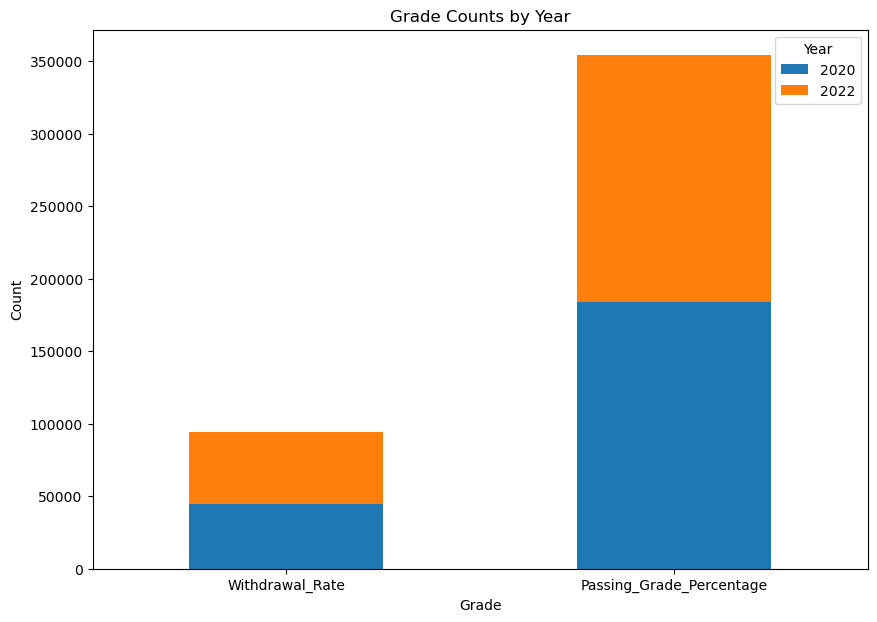

In [78]:
grade_counts_by_year = df.groupby('Year')[['Withdrawal_Rate', 'Passing_Grade_Percentage']].sum()
grade_counts_by_year.T.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Grade Counts by Year')
plt.xticks(rotation=0)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend(title='Year')
plt.show()

_______________________________________________________________________________________________________________
- ## While we are poking around the data, lets just see a bar chart with total grades for each letter grade
_______________________________________________________________________________________________________________

_______________________________________________________________________________________________________________
- ## It looks like theres not really too much of a difference in the percentages across each different year. I have to wonder what other data/ insights that I can come to by probing the data further. Let me see if I can make a model that can predict pass percentage by providing course names, instructor names, year, and withdraw count

- ## I am going to use XGBoost as it is the ML model I have the most experience with

- ## I'll be removing any rows where there is no course name available
_______________________________________________________________________________________________________________

In [83]:
df.head()

,A,B,C,Course,D,EW,F,Grand Total,Instructor,NP,P,Section,Semester,W,Year,Passing_Grade_Percentage,Withdrawal_Rate
0,19,1,0,TH ART 41,0,0,0,28,HARROP A M,0,0,3219,Spring,8,2022,71.0,29.0
1,7,0,1,TH ART 41,1,0,3,21,MARTIN A F,0,1,3220,Spring,8,2022,43.0,38.0
2,19,0,2,TH ART 41,1,0,5,32,STERLING S A,0,0,3437,Spring,5,2022,66.0,16.0
3,10,1,0,TH ART 41,0,0,0,16,HARROP A M,0,0,4283,Spring,5,2022,69.0,31.0
4,8,1,0,TH ART 41,1,0,4,22,MARTIN A F,1,0,4284,Spring,7,2022,41.0,32.0


In [86]:
df = df[df['Course'] != 'Course'] # Drop placeholder rows that have "Course" as the value

__________________________________________________________________________________________________
- ## Lets start by label encoding both the Course names and Instructor names
__________________________________________________________________________________________________

In [87]:
label_encoder = LabelEncoder()
df['Course_Encoded'] = label_encoder.fit_transform(df['Course'])
df['Instructor_Encoded'] = label_encoder.fit_transform(df['Instructor'])

__________________________________________________________________________________________________
- ## Now Lets split the data into a training and test set using only the variables we chose above
__________________________________________________________________________________________________

In [89]:
X = df[['Course_Encoded', 'Instructor_Encoded', 'W', 'Year']]
y = df['Passing_Grade_Percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

__________________________________________________________________________________________________
- ## Proceed to training and testing the model
__________________________________________________________________________________________________

In [91]:
model = xgb.XGBRegressor(objective ='reg:squarederror')                
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [95]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Root Mean Squared Error: 13.939708112073287
R-squared: 0.6077800962654262


__________________________________________________________________________________________________
- ## Well, while the RMSE isn't too promising, I do think with some hyperparameter tuning, we can build a relatively accurate model with these features. The R-squared score is also pretty good, being at least above 0.5x better than using the median to predict the values.
__________________________________________________________________________________________________

In [100]:
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

base_model = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f'Best parameters: {grid_search.best_params_}')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


In [142]:
tuned_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = .6,
                               gamma = 1, learning_rate = .005, max_depth = 20, 
                               n_estimators = 1000, subsample= 0.8)
tuned_model.fit(X_train, y_train)
predictions = tuned_model.predict(X_test)

In [143]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Root Mean Squared Error: 12.882815648552311
R-squared: 0.6650007359291711


__________________________________________________________________________________________________
- ## I didn't get much of an increase in performance, from the tuning. My guess is that with the limited amount of data I was able to retrieve, by volume alone, but also missing out on a valuable column for analysis, Department. It just wasn't salvagable as a whole. I would love to spend some more time trying to get the entirety of the data processed. I would hope to find more stable trends when given the larger sample size. 
__________________________________________________________________________________________________